In [1]:
GCS_PATH="/home/apsisdev/ansary/DATASETS/APSIS/NID/segment/"
#----------------
# imports
#---------------
import tensorflow as tf
import random
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

import numpy as np
import matplotlib.pyplot as plt
#from kaggle_datasets import KaggleDatasets
from glob import glob
from tqdm.auto import tqdm

%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [2]:
#-------------
# GCS and files and synth
#-------------
def get_tfrecs(_path):
    gcs_pattern=os.path.join(_path,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    random.shuffle(file_paths)
    return file_paths

train_recs =[]
eval_recs=[]
# synth
#GCS_PATH = KaggleDatasets().get_gcs_path('aps-nid-segment-data')  

gcs_path=os.path.join(GCS_PATH,"tfrecords")
recs =get_tfrecs(gcs_path)
train_recs+=recs[20:]
eval_recs +=recs[:20]

print(len(eval_recs),len(train_recs))

20 97


In [3]:
#-------------------------------------------------------------
# Detect hardware, return appropriate distribution strategy
#-------------------------------------------------------------

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    tf.config.optimizer.set_jit(True)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

REPLICAS:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#-------------------------
# train and data paras
#-----------------------
EPOCHS          = 500
if strategy.num_replicas_in_sync==1:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync

STEPS_PER_EPOCH = (len(train_recs)*128)//BATCH_SIZE
EVAL_STEPS      = (len(eval_recs)*128)//BATCH_SIZE
print("Steps:",STEPS_PER_EPOCH)
print("Eval Steps:",EVAL_STEPS)

Steps: 388
Eval Steps: 80


In [5]:
#-------------
# data function with tf.data api
#-------------
DIM=(256,256,3)
def data_input_fn(recs): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature([],tf.string),
                    'mask' : tf.io.FixedLenFeature([],tf.string),
                    'label' : tf.io.FixedLenFeature([2],tf.int64),
                    'bbox' : tf.io.FixedLenFeature([8],tf.int64)
        }     
        parsed_example=tf.io.parse_single_example(example,feature)
        # image
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=3)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,DIM)
        
        # mask
        mask=parsed_example['mask']
        mask=tf.image.decode_png(mask,channels=1)
        mask=tf.cast(mask,tf.float32)/255.0
        mask=tf.reshape(mask,(DIM[0],DIM[1],1))
        
        # label
        label=parsed_example['label']
        label=tf.cast(label,tf.float32)

        
        outputs={"label":label,"sigmoid":mask}
        return image,outputs

    dataset = tf.data.TFRecordDataset(recs)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(2048,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_ds  =   data_input_fn(train_recs)
eval_ds   =   data_input_fn(eval_recs)

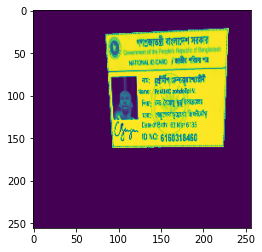

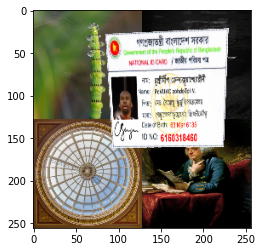

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [6]:
#-----------------------
# visual
#-----------------------
import cv2

for x,y in eval_ds.take(1):
    l=y["label"]
    m=y["sigmoid"]
    data=np.squeeze(m[0])
    plt.imshow(data)
    plt.show()
    #print(np.unique(data))
    # image
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    
    print(l[0])
    

# Modeling

```python
```

In [7]:
def get_model(data_dim=(256,256,3),num_class=2):
    unet=sm.Unet("densenet121",input_shape=data_dim,encoder_weights=None,classes=1)
    inp  =unet.input
    # class
    label=unet.get_layer(name="relu").output
    label = tf.keras.layers.GlobalAveragePooling2D()(label)
    label=tf.keras.layers.Dense(num_class,activation="softmax",name="label")(label)
    # mask
    mask=unet.output
    model=tf.keras.Model(inputs=inp,outputs=[label,mask])
    return model

In [8]:
model=get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [9]:
#---------------
# callbacks
#---------------
# weight file path
weight_path="segment.h5"

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)
# saves the model
model_autosave = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                   monitor='val_loss', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode='min')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 
callbacks= [model_autosave,lr_reducer,early_stopping]
                 
losses = {
"label":tf.keras.losses.CategoricalCrossentropy(),
"sigmoid": tf.keras.losses.BinaryCrossentropy(),
}
#---------------
# compile
#---------------    
with strategy.scope():
    # model
    model = get_model()
    model.load_weights("/home/apsisdev/ansary/CODES/apsis-nid-ocr/models/segment.h5")
    # compile
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=losses)

In [10]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS, 
                    callbacks=callbacks)

Epoch 1/500
388/388 [==============================] - 89s 196ms/step - loss: 0.1228 - label_loss: 1.7611e-06 - sigmoid_loss: 0.1228 - val_loss: 0.6147 - val_label_loss: 8.5481e-04 - val_sigmoid_loss: 0.6139

Epoch 00001: val_loss improved from inf to 0.61472, saving model to segment.h5
Epoch 2/500
388/388 [==============================] - 76s 195ms/step - loss: 0.1222 - label_loss: 9.7474e-07 - sigmoid_loss: 0.1222 - val_loss: 0.1209 - val_label_loss: 8.4237e-08 - val_sigmoid_loss: 0.1209

Epoch 00002: val_loss improved from 0.61472 to 0.12088, saving model to segment.h5
Epoch 3/500
388/388 [==============================] - 75s 194ms/step - loss: 0.1233 - label_loss: 4.4268e-07 - sigmoid_loss: 0.1233 - val_loss: 0.1206 - val_label_loss: 5.3644e-08 - val_sigmoid_loss: 0.1206

Epoch 00003: val_loss improved from 0.12088 to 0.12065, saving model to segment.h5
Epoch 4/500
388/388 [==============================] - 75s 194ms/step - loss: 0.1227 - label_loss: 1.3958e-07 - sigmoid_loss: 0.


Epoch 00030: val_loss did not improve from 0.12030
Epoch 31/500
388/388 [==============================] - 76s 195ms/step - loss: 0.1224 - label_loss: 3.7961e-07 - sigmoid_loss: 0.1224 - val_loss: 0.1203 - val_label_loss: 8.8476e-09 - val_sigmoid_loss: 0.1203

Epoch 00031: val_loss did not improve from 0.12030
Epoch 32/500
388/388 [==============================] - 75s 195ms/step - loss: 0.1236 - label_loss: 1.4832e-07 - sigmoid_loss: 0.1236 - val_loss: 0.1203 - val_label_loss: 1.1688e-08 - val_sigmoid_loss: 0.1203

Epoch 00032: val_loss did not improve from 0.12030

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 33/500
388/388 [==============================] - 76s 195ms/step - loss: 0.1229 - label_loss: 9.4834e-08 - sigmoid_loss: 0.1229 - val_loss: 0.1203 - val_label_loss: 1.0151e-08 - val_sigmoid_loss: 0.1203

Epoch 00033: val_loss improved from 0.12030 to 0.12028, saving model to segment.h5
Epoch 34/500
388/388 [==============================